#!pip install hyperopt

## Modules Import

In [13]:

from hyperopt import hp, fmin, tpe


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import yaml
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
import sys
sys.path.append("..")
from uvsw_part import simulation
import copy
from math import e
import math
import plotly.graph_objects as go

## Loading paths to List*.txt files 

In [27]:
# Path to list of time series
LIST_PATH_1 = "../data/params/List1.txt"
# Index of time series to simulate
TS_INDEX = 5

## Loading ofthe  reference model

In [28]:
# Read table of time series
data_list = pd.read_csv(LIST_PATH_1 , delim_whitespace=True)
# Get parameters of selected time series
set_params = data_list.iloc[TS_INDEX,:]
# Get dataframe of data of corresponding TS
ref = pd.read_csv("../data/ref/list1/graph{}.csv".format(set_params["nc"]))

In [ ]:
data_list

In [30]:
# Show params of selected TS
set_params

nc                    6
md                    1
U[m/s]            1.265
d[m]              0.025
m[kg/m]            1.57
L[m]                  1
H[N]                500
Nt                10000
Dt[s]            0.0004
tf[s]               4.0
ymax[m]        0.000003
filename    Data1.6.bin
Name: 5, dtype: object

## Setup of Dt and Dr to have make the simulation with the same number of points as the reference

In [31]:
# Set tf, dt and dr values based on length of observations
tf_val = set_params["tf[s]"]
dt_val = tf_val / len(ref)
dr_val = tf_val / len(ref)

## Set the search space

In [32]:
# Set the optimisation space
search_space = {
    'cable': {
        'type': 'None',
        'length': 1.0,
        'tension': hp.uniform('tension_val',25000,30000),
        'h': hp.uniform('h_val',100,1000)},
    'conductor': {'m': 1.57, 'd': 0.025, 'EA': 0.0},
    'simulation': {'ns': 101,
        'tf': tf_val,
        'dt': dt_val,
        'dr': dr_val,
        'si': 99,
        'pp': False}, ####### Enlever les prints
    'wakeosc': {'u': hp.uniform('u_val',0.05,4.0),
        'st': 0.235,
        'cl0': 0.6,
        'eps': 0.3,
        'al': 0.1,
        'bt': 0.0,
        'gm': 0.0,
        'md': 1,
        'y0': 0.0,
        'q0': 0.05}
}

## Set the objective function

In [33]:
def r2_sim(cfg):
    
    """

    Fonction permettant de calculer la fonction coût et d'afficher les graphes pour chaque itération d'hyperopt 
    Arguments : Espace de recherche (search_space)
    
    Sortie : Score calculé avec la fonction coût (1 - R2_score)
            Plot avec les valeurs proposées par Hyperopt et métriques
    
    """
    # Run simulation
    dfy, _ = run_cable_wakeosc(cfg)
    print("yes")
    # Current config
    print("#"*100)
    print("Current parameters:")
    print("\tU value: {}, \n\tH value: {}, \n\tTension value: {}, \n\tcl0 value: {}, \n\teps value: {}".format(
        cfg['wakeosc']['u'],
        cfg['cable']['h'],
        cfg['cable']['tension'],
        cfg['wakeosc']['cl0'],
        cfg['wakeosc']['eps'])
    )
    print("#"*100)
    
    # Calculate score
    score = 1.0 - r2_score(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    
    # Store score in a string for visualisation purpose
    score_text = "R2 = %s " % score

    # Plot graphics
    plt.figure(figsize = (20,5))
    plt.plot(ref['time'], ref['y/d'], label = "Signal de reference")
    plt.plot(dfy.index, dfy['s=0.250']/0.025, label = "Signal du simulateur")
    plt.xlabel('time (s)')
    plt.ylabel('y/d')
    
    # Plot score_value and parameters value
    plt.figtext(0.5, -0.05, score_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.20, "h = '{0}', tension = '{1}', u = '{2}', clo = '{3}', eps = '{4}', st = '{5}' ".format(cfg['cable']['h'],
                                                                                                                  cfg['cable']['tension'],cfg['wakeosc']['u'],cfg["wakeosc"]["cl0"],
                                                                                                                  cfg["wakeosc"]["eps"],cfg["wakeosc"]["st"]), ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    title = "Comparaison du signal de simulation avec les valeurs de paramètres fournis par HYPEROPT avec le signal de reference, Fonction objectif utilisée : R2"
    plt.title(title,fontsize=18)


    plt.legend()
    plt.show() 
    # Compute the score

    
    print("#"*40)
    print("Current scores:")
    print("\tR2 : {}".format(r2_score(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])))
    print("\tMSE : {}".format(mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])))
    print("#"*40)
    # Delete the simulation
    del dfy
    # Return the score
    return score

# Launch Hyperopt

In [ ]:
# Run the optimization process
start = time.time()
best = fmin(r2_sim, search_space, algo=tpe.suggest, max_evals=250)
end = time.time()
temps = start - end
print(temps)

In [ ]:
# Show the best parameters
best

## Data Coverage rate

We calculate a metric allowing to know the rate of values resulting from simulation included within the reference time-series for each timesteps. <br> We compare the sign of the value from the simulation and the reference for each values, and if they both share the same sign, we compare whether the simulation value has a lower amplitude than the reference one.

In [34]:
def t_couverture (ref,dfy):
    """
    Check if the reference and simulation values have the same sign one by one
     If same sign, appropriate operations to see if the amplitude of the negative or positive simulation
     is well contained in the reference 
    
    Arguments :
    ref (pandas.core.series.Series) (numpy.ndarray) : Reference model 
    dfy (numpy.ndarray)                             : Simplified model generated by the simulator 
    
    
    Sortie :
        Data coverage rate (float): Pourcentage de valeurs de la simulation 
        à l'intérieur de la réference   
    """
    same_sign = 0 # Number of the same sign in reference and simulation (taken 1 by 1)
    
    # Number of times the simulation has the same sign as the reference 
    # AND with the simulation contained in the reference (lower ampltude) 
    
    couverture = 0
    
    
    ref_taille = len(ref) # Total number of values in the reference or the simulation
    
    #Debug
    diff_sign = 0 # Number of times the sign differs between reference and simulation (taken 1 by 1) 
    
    
    for i in range(0,ref_taille):
        if(np.sign(ref[i]) == np.sign(dfy[i])): #If the reference and the sim have the same sign
            same_sign = same_sign + 1


            if(ref[i] < 0): # When the reference < 0  
                if(ref[i] - dfy[i] < 0):# Check if the reference has bigger negative amplitude than the simulation 
                    couverture = couverture + 1
                

            if(ref[i] > 0): # When the reference > 0 
                if(ref[i] - dfy[i] > 0):# Check if the reference has bigger positive amplitude than the simulation 
                    couverture = couverture + 1

            if(ref[i] == 0): # Quand la reference = 0
                if(ref[i] - dfy[i] == 0): # Check if the reference has same amplitude as the simulation
                    couverture = couverture + 1

            if(math.isnan(ref[i]) and math.isnan(dfy[i]) == True): # When the values of the reference and the simulation are both are not available (Na) 
                couverture = couverture + 1             
            
        else :
            diff_sign = diff_sign + 1 # If the reference and the simulation do not have the same sign (debug) 
            

    taux_couverture = (couverture / ref_taille) * 100 # Data coverage rate
    return taux_couverture

## Generation of a Time-Series with the simulator with a set of parameters

Here, we define the function allowing to launch the simulator with the chosen parameters and to compare the result with the reference model.
Visualizations are made with Matplotlib and Plotly

In [35]:
def generate_ts(u,h,tension,clo,LIST_PATH,TS_INDEX) :
    
    """
    Fonction utilisant les paramètres de u,h,tension,cl0 pour génerer une Time-Series de simulation.
    Comparaison du modèle de simulation ave le modèle de réference chargé avec le fichier Liste souhaité et l'index de la Time-Series
    
    Arguments : 
        u (float)          : Paramètre
        h (float)          : Paramètre
        tension (float)    : Paramètre
        cl0 (float)        : Paramètre
        LIST_PATH (string) : Chemin vers le fichier Liste
        TS_INDEX (int)     : Index de la Time-Series à charger (commence à 0) 
    
    Sortie : 
        Visualisation graphique du modèle simplifié et du modèle de réference avec Matplotlib
        Visualisation graĥique du modèle simplifié et du modèle de réference Plotly
    
    """

    #Chargement du fichier List*.txt avec le chemin
    data_list = pd.read_csv(LIST_PATH, delim_whitespace=True)
    
    #Chargement des paramètres de base d'une Time-Series pour la simulation avec son index (Index commence à 0)
    set_params = data_list.iloc[TS_INDEX,:]

    #Chargement des Time-Series de réference selon le fichier Liste utilisé
    list_number = LIST_PATH[-9:]

    if(list_number == "List1.txt"):
        ref = pd.read_csv("../data/ref/list1/graph{}.csv".format(set_params["nc"]))
        print("Chargement du fichier Liste : Liste_1")
    if(list_number == "List2.txt"):
        ref = pd.read_csv("../data/ref/list2/graph{}.csv".format(set_params["nc"]))
        print("Chargement du fichier Liste : Liste_2")
    if(list_number !=  "List1.txt" and list_number != "List2.txt" ):
        print("Erreur, Numéro de liste non supporté")
    
    
    
    
    #Chargement du fichier YAML contenant la liste des paramètres
    cfg = yaml.safe_load(open('../data/config/example.in.yaml', 'r'))

    #Chargement des paramètres à tester 
    cfg["cable"]["h"] = float(h)
    cfg["cable"]["tension"] = float(tension)
    cfg["wakeosc"]["u"] = float(u)
    cfg["wakeosc"]["cl0"]= float(clo)

    #Setup des paramètres permettant de produire un modèle simplifié de même longueur que le modèle de réference
    cfg["simulation"]["tf"] = float(set_params["tf[s]"])
    cfg["simulation"]["dt"] = cfg["simulation"]["tf"] / len(ref) 
    cfg["simulation"]["dr"] = cfg["simulation"]["tf"] / len(ref) 



    print("h Value: ", cfg["cable"]["h"], " u Value: ", cfg["wakeosc"]["u"]," tension Value: ",cfg["cable"]["tension"])
    print("tf Value ", cfg["simulation"]["tf"])
    
    # Lancement du simulateur
    dfy, _ = simulation.run_cable_wakeosc(cfg)
    
    #Calcul des métriques
    mse = mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    rmse = mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1],squared = False)
    mea = mean_absolute_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    r2 = r2_score(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    taux_couverture = t_couverture(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    
    
    #Stockage des métriques sous format texte en vue de la visualisation
    mse_text= "MSE = %s " % mse
    rmse_text = "RMSE = %s " % rmse
    mea_text = "MEA = %s " % mea
    r2_text = "R2 = %s " % r2
    taux_couverture_text = "Coverage = %s %%" % taux_couverture


    #Visualisation avec Matplotlib
    plt.figure(figsize = (20,8))
    plt.plot(ref['time'], ref['y/d'], label = "Reference model signal")
    plt.plot(dfy.index, dfy['s=0.250']/0.025, label = "Simulator signal")
    plt.xlabel('Time (s)',fontsize=18)
    plt.ylabel('Signal',fontsize=18)

    #Affichage des métriques dans la visualisation
    plt.figtext(0.5, 0.00, mse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.05, rmse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.10, mea_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.15, r2_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    
    plt.figtext(0.5, -0.25, "h = '{0}', tension = '{1}', u = '{2}', clo = '{3}', eps = '{4}'".format(cfg['cable']['h'],cfg['cable']['tension'],cfg['wakeosc']['u'],cfg["wakeosc"]["cl0"],cfg["wakeosc"]["eps"]), ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.30, taux_couverture_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    title = "Comparison between the signal of the simulation and signal of the reference model"
    plt.title(title,fontsize=18)

    plt.legend()
    plt.show() 

    
    # Visualisation avec Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ref['time'], y=ref['y/d'],
                    name='Reference model signal'))
    fig.add_trace(go.Scatter(x=dfy.index, y=dfy['s=0.250']/0.025,
                    name='Simulator signal'))
    
    fig.update_layout(
        title="Comparison between the signal of the simulation and signal of the reference model",
        xaxis_title="Time (s)",
        yaxis_title="Signal",
        legend_title="Signals",
    )

    fig.show()


Chargement du fichier Liste : Liste_1
h Value:  621.7839075191669  u Value:  0.955211196845402  tension Value:  27025.114328618747
tf Value  4.0
Nombres de valeurs au total = 10000
Nombres de valeurs dans sim et ref avec le même signe = 7940
Nombres de valeurs avec sim et ref avec signes differents = 2060
----------------------------------
Total des 2 par rapport à la reference = 10000 / 10000
Nombres de valeurs dans sim et ref avec le même signe ET couverts = 4666 / 7940
----------------------------------
Pourcentage de couverture : 46.660000000000004%


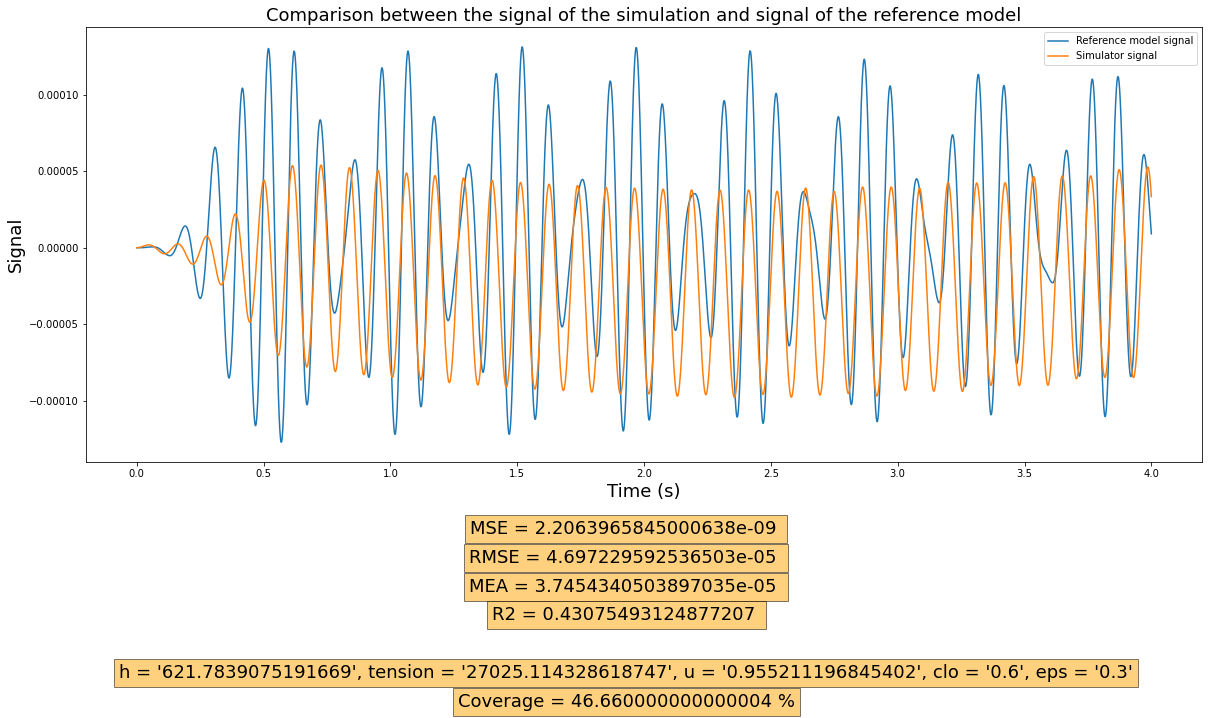

In [37]:
generate_ts(u = 0.955211196845402,h = 621.7839075191669,
                       tension = 27025.114328618747,clo = 0.6,
                      LIST_PATH  = LIST_PATH_1,TS_INDEX = 5)